# 題醒

**未處理圖片檔目錄**

    ./Non-processed/

**分割後圖片檔目錄**

    ./Nums/
    


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#題醒" data-toc-modified-id="題醒-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>題醒</a></span></li><li><span><a href="#參考資源" data-toc-modified-id="參考資源-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>參考資源</a></span></li><li><span><a href="#存儲驗證碼" data-toc-modified-id="存儲驗證碼-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>存儲驗證碼</a></span></li><li><span><a href="#驗證碼分割儲存" data-toc-modified-id="驗證碼分割儲存-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>驗證碼分割儲存</a></span></li><li><span><a href="#辨識驗證碼" data-toc-modified-id="辨識驗證碼-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>辨識驗證碼</a></span></li></ul></div>

# 參考資源

[爬蟲實戰] 如何使用機器學習方法破解驗證碼 (4) ? – 如何存取訓練模型

[jupyter](https://nbviewer.jupyter.org/github/ywchiu/largitdata/blob/master/code/Course_94.ipynb)

[youtube](https://www.youtube.com/watch?v=kYSxf1V-VV4)

# 存儲驗證碼

In [ ]:
import requests
# 保持會話
rs  = requests.session()
# login網址
res = rs.get('http://gcis.nat.gov.tw/pub/cmpy/cmpyInfoListAction.do')
with open('kaptcha.jpg', 'wb') as f:
    # 驗證碼生成網址
    res2 = rs.get('http://gcis.nat.gov.tw/pub/kaptcha.jpg')
    f.write(res2.content)

In [76]:
import requests
with open('kaptcha.jpg', 'wb') as f:
    res = requests.get('https://pfcf.lineapia.tw/web/verfiyNumber.php?c=56')
    f.write(res.content)

766

# 驗證碼分割儲存

In [2]:
import cv2
import numpy as np

In [3]:
%pylab inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


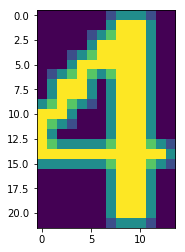

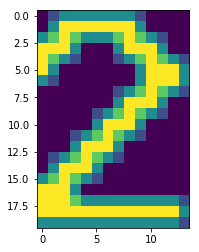

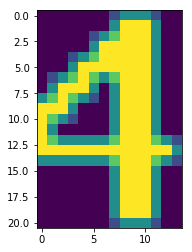

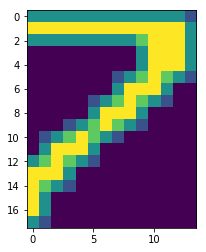

In [5]:
# 灰度化
img = cv2.imread('kaptcha.jpg',0) # 讀進來就是灰度化的數字陣列
#imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 過濾 二值化
# 大於10則返回255，否則 0，此數字要調適
# 區分出數字與其他背景的區別
ret, thresh = cv2.threshold(img, 10, 255, 0)

# 團聚分割，以像素點的聚集作為依據
# 缺點，驗證碼中的數字，若有重疊，會判斷為一塊(粗糙的做法，直接剖半)
# contours 一連串的點，之後用到
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 依 x 排序各個團聚
# boundingRect，界定出團聚的邊界
# 返回 (x,y,w,h) : x,y座標點， w,h寬高
cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x:x[1])

# 有時切出來的團塊並非完整數字
# 依據 w,h 寬高 判斷
ary = []
for (c,_) in cnts:
    (x,y,w,h) = cv2.boundingRect(c)
    #print((x,y,w,h))
    #ary.append((x,y,w,h) )
    if w >= 10 and h >= 15 :
        ary.append((x,y,w,h) )

# 儲存圖片 
# 儲存後大小均為 600X400
for id, (x,y,w,h) in enumerate(ary):
    fig = plt.figure()
    roi = img[y:y+h, x:x+w]
    thresh = roi.copy()
    plt.imshow(thresh)
    plt.savefig(f'kaptcha_{id}.jpg', dpi=100)

# 辨識驗證碼

In [65]:
from sklearn.externals import joblib

clf = joblib.load('captcha.pkl') 

scaler = joblib.load("scaler.pkl") 

In [45]:
import PIL

StandardScaler(copy=True, with_mean=True, with_std=True)

array([4, 2, 3, 7])

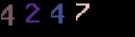

In [78]:
basewidth = 50

data = []
for i in range(4):
    # 圖片轉小
    pil_image = PIL.Image.open(f'kaptcha_{i}.jpg').convert('1') 
    wpercent = (basewidth/float(pil_image.size[0]))
    hsize = int((float(pil_image.size[1])*float(wpercent)))
    img = pil_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
    data.append([pixel for pixel in iter(img.getdata())])
scaler.fit(data)
data_scaled = scaler.transform(data)
clf.predict(data_scaled)

PIL.Image.open('kaptcha.jpg')